In [13]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random

In [14]:
def get_dihedrals_all_replicas(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}ns.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}ns_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    print(n_iter)
    n_iter = 1000
    
    from tqdm import tqdm
    dihedrals_master = []
    all_pos_hybrid_master = []
    for j in [0]:
        index = j # of replica
        all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
        all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
        all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
        for iteration in tqdm(range(0, n_iter)):
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
            pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
            all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
            all_pos_hybrid[iteration] = pos # Get hybrid positions
#             all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

        all_pos_hybrid_master.append(all_pos_hybrid)
        
        dihedrals_all = []
        for pos, top, indices in zip([all_pos_new], [new_top], [dihedral_indices_new]):
            traj = md.Trajectory(np.array(pos), top)
    #         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices])))
            dihedrals = md.compute_dihedrals(traj, np.array([indices]))
            dihedrals_all.append(dihedrals)
#         traj = md.Trajectory(np.array(all_pos_old), old_top)
#         dihedrals = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
#         dihedrals_all.append(dihedrals)
#         dihedrals_master.append(dihedrals_all)
    return dihedrals_all, n_iter, all_pos_hybrid_master

def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
#     plt.savefig(outfile, dpi=300)
    plt.close()

def plot_time_series(dihedrals, n_iter, outfile):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("dihedral")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
    plt.close()

    return uncorrelated_indices

def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
#     plt.savefig(outfile, dpi=300)
    plt.close()



In [15]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/12/80/"
name = "LYS"
endstate = 1
phase = "complex"
length = 1
i = os.path.basename(os.path.dirname(outdir))
aa = name.lower()


In [16]:
with open(os.path.join(outdir, f"{i}_{phase}_{endstate}.pickle"), 'rb') as f:
    htf = pickle.load(f)


In [6]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.residue.id)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 1 (C) of chain 0 residue 0 (ACE)> 2
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 2
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 2
<Atom 6 (N) of chain 0 residue 1 (VAL)> 3
<Atom 7 (CA) of chain 0 residue 1 (VAL)> 3
<Atom 8 (C) of chain 0 residue 1 (VAL)> 3
<Atom 9 (O) of chain 0 residue 1 (VAL)> 3
<Atom 10 (CB) of chain 0 residue 1 (VAL)> 3
<Atom 11 (CG1) of chain 0 residue 1 (VAL)> 3
<Atom 12 (CG2) of chain 0 residue 1 (VAL)> 3
<Atom 13 (H) of chain 0 residue 1 (VAL)> 3
<Atom 14 (HA) of chain 0 residue 1 (VAL)> 3
<Atom 15 (HB) of chain 0 residue 1 (VAL)> 3
<Atom 16 (HG11) of chain 0 residue 1 (VAL)> 3
<Atom 17 (HG12) of chain 0 residue 1 (VAL)> 3
<Atom 18 (HG13) of chain 0 residue 1 (VAL)> 3
<Atom 19 (HG21) of chain 0 residue 1 (VAL)> 3
<Atom 20 (HG22) of chain 0 residue 1 (VAL)> 3
<Atom 21 (HG23) of chain 0 residue 1 (VAL)> 3
<Atom 22 (N) of chain 0 residue 2

<Atom 1979 (CD2) of chain 1 residue 127 (HIS)> 17
<Atom 1980 (CE1) of chain 1 residue 127 (HIS)> 17
<Atom 1981 (NE2) of chain 1 residue 127 (HIS)> 17
<Atom 1982 (H) of chain 1 residue 127 (HIS)> 17
<Atom 1983 (HA) of chain 1 residue 127 (HIS)> 17
<Atom 1984 (HB3) of chain 1 residue 127 (HIS)> 17
<Atom 1985 (HB2) of chain 1 residue 127 (HIS)> 17
<Atom 1986 (HD2) of chain 1 residue 127 (HIS)> 17
<Atom 1987 (HE1) of chain 1 residue 127 (HIS)> 17
<Atom 1988 (HE2) of chain 1 residue 127 (HIS)> 17
<Atom 1989 (N) of chain 1 residue 128 (GLN)> 18
<Atom 1990 (CA) of chain 1 residue 128 (GLN)> 18
<Atom 1991 (C) of chain 1 residue 128 (GLN)> 18
<Atom 1992 (O) of chain 1 residue 128 (GLN)> 18
<Atom 1993 (CB) of chain 1 residue 128 (GLN)> 18
<Atom 1994 (CG) of chain 1 residue 128 (GLN)> 18
<Atom 1995 (CD) of chain 1 residue 128 (GLN)> 18
<Atom 1996 (OE1) of chain 1 residue 128 (GLN)> 18
<Atom 1997 (NE2) of chain 1 residue 128 (GLN)> 18
<Atom 1998 (H) of chain 1 residue 128 (GLN)> 18
<Atom 1999 (HA)

<Atom 4228 (H1) of chain 3 residue 560 (HOH)> 563
<Atom 4229 (H2) of chain 3 residue 560 (HOH)> 563
<Atom 4230 (O) of chain 3 residue 561 (HOH)> 564
<Atom 4231 (H1) of chain 3 residue 561 (HOH)> 564
<Atom 4232 (H2) of chain 3 residue 561 (HOH)> 564
<Atom 4233 (O) of chain 3 residue 562 (HOH)> 565
<Atom 4234 (H1) of chain 3 residue 562 (HOH)> 565
<Atom 4235 (H2) of chain 3 residue 562 (HOH)> 565
<Atom 4236 (O) of chain 3 residue 563 (HOH)> 566
<Atom 4237 (H1) of chain 3 residue 563 (HOH)> 566
<Atom 4238 (H2) of chain 3 residue 563 (HOH)> 566
<Atom 4239 (O) of chain 3 residue 564 (HOH)> 567
<Atom 4240 (H1) of chain 3 residue 564 (HOH)> 567
<Atom 4241 (H2) of chain 3 residue 564 (HOH)> 567
<Atom 4242 (O) of chain 3 residue 565 (HOH)> 568
<Atom 4243 (H1) of chain 3 residue 565 (HOH)> 568
<Atom 4244 (H2) of chain 3 residue 565 (HOH)> 568
<Atom 4245 (O) of chain 3 residue 566 (HOH)> 569
<Atom 4246 (H1) of chain 3 residue 566 (HOH)> 569
<Atom 4247 (H2) of chain 3 residue 566 (HOH)> 569
<Atom 

<Atom 6478 (H1) of chain 3 residue 1310 (HOH)> 1313
<Atom 6479 (H2) of chain 3 residue 1310 (HOH)> 1313
<Atom 6480 (O) of chain 3 residue 1311 (HOH)> 1314
<Atom 6481 (H1) of chain 3 residue 1311 (HOH)> 1314
<Atom 6482 (H2) of chain 3 residue 1311 (HOH)> 1314
<Atom 6483 (O) of chain 3 residue 1312 (HOH)> 1315
<Atom 6484 (H1) of chain 3 residue 1312 (HOH)> 1315
<Atom 6485 (H2) of chain 3 residue 1312 (HOH)> 1315
<Atom 6486 (O) of chain 3 residue 1313 (HOH)> 1316
<Atom 6487 (H1) of chain 3 residue 1313 (HOH)> 1316
<Atom 6488 (H2) of chain 3 residue 1313 (HOH)> 1316
<Atom 6489 (O) of chain 3 residue 1314 (HOH)> 1317
<Atom 6490 (H1) of chain 3 residue 1314 (HOH)> 1317
<Atom 6491 (H2) of chain 3 residue 1314 (HOH)> 1317
<Atom 6492 (O) of chain 3 residue 1315 (HOH)> 1318
<Atom 6493 (H1) of chain 3 residue 1315 (HOH)> 1318
<Atom 6494 (H2) of chain 3 residue 1315 (HOH)> 1318
<Atom 6495 (O) of chain 3 residue 1316 (HOH)> 1319
<Atom 6496 (H1) of chain 3 residue 1316 (HOH)> 1319
<Atom 6497 (H2) of

<Atom 8728 (H1) of chain 3 residue 2060 (HOH)> 2065
<Atom 8729 (H2) of chain 3 residue 2060 (HOH)> 2065
<Atom 8730 (O) of chain 3 residue 2061 (HOH)> 2066
<Atom 8731 (H1) of chain 3 residue 2061 (HOH)> 2066
<Atom 8732 (H2) of chain 3 residue 2061 (HOH)> 2066
<Atom 8733 (O) of chain 3 residue 2062 (HOH)> 2067
<Atom 8734 (H1) of chain 3 residue 2062 (HOH)> 2067
<Atom 8735 (H2) of chain 3 residue 2062 (HOH)> 2067
<Atom 8736 (O) of chain 3 residue 2063 (HOH)> 2068
<Atom 8737 (H1) of chain 3 residue 2063 (HOH)> 2068
<Atom 8738 (H2) of chain 3 residue 2063 (HOH)> 2068
<Atom 8739 (O) of chain 3 residue 2064 (HOH)> 2069
<Atom 8740 (H1) of chain 3 residue 2064 (HOH)> 2069
<Atom 8741 (H2) of chain 3 residue 2064 (HOH)> 2069
<Atom 8742 (O) of chain 3 residue 2065 (HOH)> 2070
<Atom 8743 (H1) of chain 3 residue 2065 (HOH)> 2070
<Atom 8744 (H2) of chain 3 residue 2065 (HOH)> 2070
<Atom 8745 (O) of chain 3 residue 2066 (HOH)> 2071
<Atom 8746 (H1) of chain 3 residue 2066 (HOH)> 2071
<Atom 8747 (H2) of

<Atom 10978 (H1) of chain 3 residue 2810 (HOH)> 2815
<Atom 10979 (H2) of chain 3 residue 2810 (HOH)> 2815
<Atom 10980 (O) of chain 3 residue 2811 (HOH)> 2816
<Atom 10981 (H1) of chain 3 residue 2811 (HOH)> 2816
<Atom 10982 (H2) of chain 3 residue 2811 (HOH)> 2816
<Atom 10983 (O) of chain 3 residue 2812 (HOH)> 2817
<Atom 10984 (H1) of chain 3 residue 2812 (HOH)> 2817
<Atom 10985 (H2) of chain 3 residue 2812 (HOH)> 2817
<Atom 10986 (O) of chain 3 residue 2813 (HOH)> 2818
<Atom 10987 (H1) of chain 3 residue 2813 (HOH)> 2818
<Atom 10988 (H2) of chain 3 residue 2813 (HOH)> 2818
<Atom 10989 (O) of chain 3 residue 2814 (HOH)> 2819
<Atom 10990 (H1) of chain 3 residue 2814 (HOH)> 2819
<Atom 10991 (H2) of chain 3 residue 2814 (HOH)> 2819
<Atom 10992 (O) of chain 3 residue 2815 (HOH)> 2820
<Atom 10993 (H1) of chain 3 residue 2815 (HOH)> 2820
<Atom 10994 (H2) of chain 3 residue 2815 (HOH)> 2820
<Atom 10995 (O) of chain 3 residue 2816 (HOH)> 2821
<Atom 10996 (H1) of chain 3 residue 2816 (HOH)> 2821

<Atom 13227 (O) of chain 3 residue 3560 (HOH)> 3566
<Atom 13228 (H1) of chain 3 residue 3560 (HOH)> 3566
<Atom 13229 (H2) of chain 3 residue 3560 (HOH)> 3566
<Atom 13230 (O) of chain 3 residue 3561 (HOH)> 3567
<Atom 13231 (H1) of chain 3 residue 3561 (HOH)> 3567
<Atom 13232 (H2) of chain 3 residue 3561 (HOH)> 3567
<Atom 13233 (O) of chain 3 residue 3562 (HOH)> 3568
<Atom 13234 (H1) of chain 3 residue 3562 (HOH)> 3568
<Atom 13235 (H2) of chain 3 residue 3562 (HOH)> 3568
<Atom 13236 (O) of chain 3 residue 3563 (HOH)> 3569
<Atom 13237 (H1) of chain 3 residue 3563 (HOH)> 3569
<Atom 13238 (H2) of chain 3 residue 3563 (HOH)> 3569
<Atom 13239 (O) of chain 3 residue 3564 (HOH)> 3570
<Atom 13240 (H1) of chain 3 residue 3564 (HOH)> 3570
<Atom 13241 (H2) of chain 3 residue 3564 (HOH)> 3570
<Atom 13242 (O) of chain 3 residue 3565 (HOH)> 3571
<Atom 13243 (H1) of chain 3 residue 3565 (HOH)> 3571
<Atom 13244 (H2) of chain 3 residue 3565 (HOH)> 3571
<Atom 13245 (O) of chain 3 residue 3566 (HOH)> 3572


<Atom 15477 (O) of chain 3 residue 4310 (HOH)> 4317
<Atom 15478 (H1) of chain 3 residue 4310 (HOH)> 4317
<Atom 15479 (H2) of chain 3 residue 4310 (HOH)> 4317
<Atom 15480 (O) of chain 3 residue 4311 (HOH)> 4318
<Atom 15481 (H1) of chain 3 residue 4311 (HOH)> 4318
<Atom 15482 (H2) of chain 3 residue 4311 (HOH)> 4318
<Atom 15483 (O) of chain 3 residue 4312 (HOH)> 4319
<Atom 15484 (H1) of chain 3 residue 4312 (HOH)> 4319
<Atom 15485 (H2) of chain 3 residue 4312 (HOH)> 4319
<Atom 15486 (O) of chain 3 residue 4313 (HOH)> 4320
<Atom 15487 (H1) of chain 3 residue 4313 (HOH)> 4320
<Atom 15488 (H2) of chain 3 residue 4313 (HOH)> 4320
<Atom 15489 (O) of chain 3 residue 4314 (HOH)> 4321
<Atom 15490 (H1) of chain 3 residue 4314 (HOH)> 4321
<Atom 15491 (H2) of chain 3 residue 4314 (HOH)> 4321
<Atom 15492 (O) of chain 3 residue 4315 (HOH)> 4322
<Atom 15493 (H1) of chain 3 residue 4315 (HOH)> 4322
<Atom 15494 (H2) of chain 3 residue 4315 (HOH)> 4322
<Atom 15495 (O) of chain 3 residue 4316 (HOH)> 4323


<Atom 17727 (O) of chain 3 residue 5060 (HOH)> 5071
<Atom 17728 (H1) of chain 3 residue 5060 (HOH)> 5071
<Atom 17729 (H2) of chain 3 residue 5060 (HOH)> 5071
<Atom 17730 (O) of chain 3 residue 5061 (HOH)> 5072
<Atom 17731 (H1) of chain 3 residue 5061 (HOH)> 5072
<Atom 17732 (H2) of chain 3 residue 5061 (HOH)> 5072
<Atom 17733 (O) of chain 3 residue 5062 (HOH)> 5073
<Atom 17734 (H1) of chain 3 residue 5062 (HOH)> 5073
<Atom 17735 (H2) of chain 3 residue 5062 (HOH)> 5073
<Atom 17736 (O) of chain 3 residue 5063 (HOH)> 5074
<Atom 17737 (H1) of chain 3 residue 5063 (HOH)> 5074
<Atom 17738 (H2) of chain 3 residue 5063 (HOH)> 5074
<Atom 17739 (O) of chain 3 residue 5064 (HOH)> 5075
<Atom 17740 (H1) of chain 3 residue 5064 (HOH)> 5075
<Atom 17741 (H2) of chain 3 residue 5064 (HOH)> 5075
<Atom 17742 (O) of chain 3 residue 5065 (HOH)> 5076
<Atom 17743 (H1) of chain 3 residue 5065 (HOH)> 5076
<Atom 17744 (H2) of chain 3 residue 5065 (HOH)> 5076
<Atom 17745 (O) of chain 3 residue 5066 (HOH)> 5077


<Atom 19977 (O) of chain 3 residue 5810 (HOH)> 5824
<Atom 19978 (H1) of chain 3 residue 5810 (HOH)> 5824
<Atom 19979 (H2) of chain 3 residue 5810 (HOH)> 5824
<Atom 19980 (O) of chain 3 residue 5811 (HOH)> 5825
<Atom 19981 (H1) of chain 3 residue 5811 (HOH)> 5825
<Atom 19982 (H2) of chain 3 residue 5811 (HOH)> 5825
<Atom 19983 (O) of chain 3 residue 5812 (HOH)> 5826
<Atom 19984 (H1) of chain 3 residue 5812 (HOH)> 5826
<Atom 19985 (H2) of chain 3 residue 5812 (HOH)> 5826
<Atom 19986 (O) of chain 3 residue 5813 (HOH)> 5827
<Atom 19987 (H1) of chain 3 residue 5813 (HOH)> 5827
<Atom 19988 (H2) of chain 3 residue 5813 (HOH)> 5827
<Atom 19989 (O) of chain 3 residue 5814 (HOH)> 5828
<Atom 19990 (H1) of chain 3 residue 5814 (HOH)> 5828
<Atom 19991 (H2) of chain 3 residue 5814 (HOH)> 5828
<Atom 19992 (O) of chain 3 residue 5815 (HOH)> 5829
<Atom 19993 (H1) of chain 3 residue 5815 (HOH)> 5829
<Atom 19994 (H2) of chain 3 residue 5815 (HOH)> 5829
<Atom 19995 (O) of chain 3 residue 5816 (HOH)> 5830


<Atom 22476 (O) of chain 3 residue 6643 (HOH)> 6659
<Atom 22477 (H1) of chain 3 residue 6643 (HOH)> 6659
<Atom 22478 (H2) of chain 3 residue 6643 (HOH)> 6659
<Atom 22479 (O) of chain 3 residue 6644 (HOH)> 6660
<Atom 22480 (H1) of chain 3 residue 6644 (HOH)> 6660
<Atom 22481 (H2) of chain 3 residue 6644 (HOH)> 6660
<Atom 22482 (O) of chain 3 residue 6645 (HOH)> 6661
<Atom 22483 (H1) of chain 3 residue 6645 (HOH)> 6661
<Atom 22484 (H2) of chain 3 residue 6645 (HOH)> 6661
<Atom 22485 (O) of chain 3 residue 6646 (HOH)> 6662
<Atom 22486 (H1) of chain 3 residue 6646 (HOH)> 6662
<Atom 22487 (H2) of chain 3 residue 6646 (HOH)> 6662
<Atom 22488 (O) of chain 3 residue 6647 (HOH)> 6663
<Atom 22489 (H1) of chain 3 residue 6647 (HOH)> 6663
<Atom 22490 (H2) of chain 3 residue 6647 (HOH)> 6663
<Atom 22491 (O) of chain 3 residue 6648 (HOH)> 6664
<Atom 22492 (H1) of chain 3 residue 6648 (HOH)> 6664
<Atom 22493 (H2) of chain 3 residue 6648 (HOH)> 6664
<Atom 22494 (O) of chain 3 residue 6649 (HOH)> 6665


<Atom 24976 (H1) of chain 3 residue 7476 (HOH)> 7494
<Atom 24977 (H2) of chain 3 residue 7476 (HOH)> 7494
<Atom 24978 (O) of chain 3 residue 7477 (HOH)> 7495
<Atom 24979 (H1) of chain 3 residue 7477 (HOH)> 7495
<Atom 24980 (H2) of chain 3 residue 7477 (HOH)> 7495
<Atom 24981 (O) of chain 3 residue 7478 (HOH)> 7496
<Atom 24982 (H1) of chain 3 residue 7478 (HOH)> 7496
<Atom 24983 (H2) of chain 3 residue 7478 (HOH)> 7496
<Atom 24984 (O) of chain 3 residue 7479 (HOH)> 7497
<Atom 24985 (H1) of chain 3 residue 7479 (HOH)> 7497
<Atom 24986 (H2) of chain 3 residue 7479 (HOH)> 7497
<Atom 24987 (O) of chain 3 residue 7480 (HOH)> 7498
<Atom 24988 (H1) of chain 3 residue 7480 (HOH)> 7498
<Atom 24989 (H2) of chain 3 residue 7480 (HOH)> 7498
<Atom 24990 (O) of chain 3 residue 7481 (HOH)> 7499
<Atom 24991 (H1) of chain 3 residue 7481 (HOH)> 7499
<Atom 24992 (H2) of chain 3 residue 7481 (HOH)> 7499
<Atom 24993 (O) of chain 3 residue 7482 (HOH)> 7500
<Atom 24994 (H1) of chain 3 residue 7482 (HOH)> 7500

<Atom 27476 (H2) of chain 3 residue 8309 (HOH)> 8331
<Atom 27477 (O) of chain 3 residue 8310 (HOH)> 8332
<Atom 27478 (H1) of chain 3 residue 8310 (HOH)> 8332
<Atom 27479 (H2) of chain 3 residue 8310 (HOH)> 8332
<Atom 27480 (O) of chain 3 residue 8311 (HOH)> 8333
<Atom 27481 (H1) of chain 3 residue 8311 (HOH)> 8333
<Atom 27482 (H2) of chain 3 residue 8311 (HOH)> 8333
<Atom 27483 (O) of chain 3 residue 8312 (HOH)> 8334
<Atom 27484 (H1) of chain 3 residue 8312 (HOH)> 8334
<Atom 27485 (H2) of chain 3 residue 8312 (HOH)> 8334
<Atom 27486 (O) of chain 3 residue 8313 (HOH)> 8335
<Atom 27487 (H1) of chain 3 residue 8313 (HOH)> 8335
<Atom 27488 (H2) of chain 3 residue 8313 (HOH)> 8335
<Atom 27489 (O) of chain 3 residue 8314 (HOH)> 8336
<Atom 27490 (H1) of chain 3 residue 8314 (HOH)> 8336
<Atom 27491 (H2) of chain 3 residue 8314 (HOH)> 8336
<Atom 27492 (O) of chain 3 residue 8315 (HOH)> 8337
<Atom 27493 (H1) of chain 3 residue 8315 (HOH)> 8337
<Atom 27494 (H2) of chain 3 residue 8315 (HOH)> 8337

In [8]:
indices_old = [390, 391, 394, 399]
indices_new = [390, 391, 394, 399]

In [9]:
dihedrals, n_iter, all_pos_hybrid = get_dihedrals_all_replicas(i, aa, length, outdir, htf, indices_new, indices_old)                                       


  0%|          | 0/1000 [00:00<?, ?it/s]

1001


100%|██████████| 1000/1000 [35:58<00:00,  2.16s/it]


In [11]:
# with open(os.path.join(outdir, "all_pos_hybrid.npy"), 'wb') as f:
#     np.save(f, all_pos_hybrid)

In [17]:
with open(os.path.join(outdir, "all_pos_hybrid.npy"), 'rb') as f:
    all_pos_hybrid = np.load(f)

In [34]:
all_pos_hybrid.shape

(1, 1000, 29458, 3)

In [36]:
new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
for iteration in tqdm(range(0, 1000)):
    pos = all_pos_hybrid[0][iteration]
    all_pos_new[iteration] = htf.new_positions(pos*unit.nanometers) # Get new positions only



100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


NameError: name 'dihedral_indices_new' is not defined

In [37]:
for pos, top, indices in zip([all_pos_new], [new_top], [indices_new]):
    traj = md.Trajectory(np.array(pos), top)
#         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices])))
    dihedrals = md.compute_dihedrals(traj, np.array([indices]))


INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


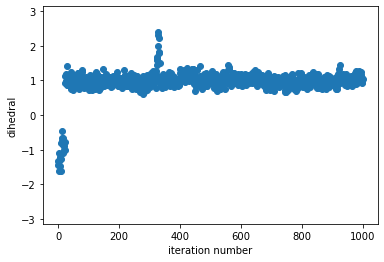

In [40]:
dihedrals_new = dihedrals
plot_dihedrals(dihedrals_new, os.path.join(outdir, f"correlated.png"))
uncorrelated_new = plot_time_series(dihedrals_new, n_iter, os.path.join(outdir, f"timeseries.png"))
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new, os.path.join(outdir, f"decorrelated.png"))

(-3.141592653589793, 3.141592653589793)

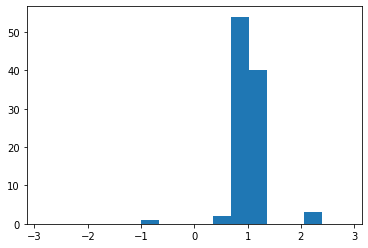

In [71]:
uncorrelated_indices = uncorrelated_new
subset_indices = random.choices(uncorrelated_indices, k=100) 
plt.hist(dihedrals[subset_indices])
plt.xlim([-np.pi, np.pi])

In [69]:
uncorrelated_indices

[21,
 27,
 34,
 40,
 47,
 53,
 59,
 66,
 72,
 79,
 85,
 91,
 98,
 104,
 111,
 117,
 123,
 130,
 136,
 143,
 149,
 155,
 162,
 168,
 175,
 181,
 187,
 194,
 200,
 207,
 213,
 219,
 226,
 232,
 239,
 245,
 251,
 258,
 264,
 271,
 277,
 283,
 290,
 296,
 303,
 309,
 315,
 322,
 328,
 335,
 341,
 347,
 354,
 360,
 367,
 373,
 379,
 386,
 392,
 399,
 405,
 411,
 418,
 424,
 431,
 437,
 443,
 450,
 456,
 463,
 469,
 475,
 482,
 488,
 495,
 501,
 507,
 514,
 520,
 527,
 533,
 539,
 546,
 552,
 559,
 565,
 571,
 578,
 584,
 591,
 597,
 603,
 610,
 616,
 623,
 629,
 635,
 642,
 648,
 655,
 661,
 667,
 674,
 680,
 687,
 693,
 699,
 706,
 712,
 719,
 725,
 732,
 738,
 744,
 751,
 757,
 764,
 770,
 776,
 783,
 789,
 796,
 802,
 808,
 815,
 821,
 828,
 834,
 840,
 847,
 853,
 860,
 866,
 872,
 879,
 885,
 892,
 898,
 904,
 911,
 917,
 924,
 930,
 936,
 943,
 949,
 956,
 962,
 968,
 975,
 981,
 988,
 994]

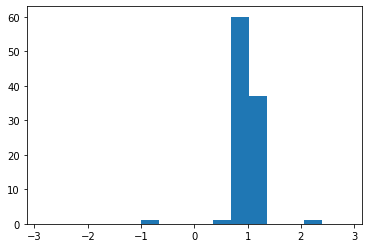

In [110]:
uncorrelated_indices = uncorrelated_new
subset_indices = random.sample(uncorrelated_indices, k=100) 
plt.hist(dihedrals[subset_indices])
plt.xlim([-np.pi, np.pi])
plt.show()

In [111]:
for i, dihedral in enumerate(dihedrals[uncorrelated_indices]):
    if dihedral < 0:
        print(i, dihedral)

0 [-1.0074598]


In [112]:
uncorrelated_indices[0]

21

In [113]:
subset_indices

[968,
 443,
 693,
 539,
 815,
 431,
 488,
 296,
 149,
 360,
 181,
 379,
 642,
 463,
 251,
 303,
 911,
 347,
 104,
 91,
 328,
 392,
 79,
 552,
 904,
 194,
 738,
 123,
 571,
 629,
 603,
 53,
 111,
 21,
 168,
 47,
 162,
 559,
 712,
 424,
 796,
 719,
 847,
 802,
 783,
 892,
 418,
 335,
 808,
 578,
 501,
 616,
 258,
 482,
 936,
 930,
 27,
 623,
 687,
 866,
 469,
 776,
 853,
 405,
 207,
 661,
 751,
 732,
 994,
 988,
 917,
 840,
 949,
 66,
 437,
 367,
 706,
 680,
 565,
 584,
 533,
 475,
 315,
 271,
 764,
 175,
 674,
 597,
 520,
 136,
 34,
 232,
 130,
 591,
 264,
 277,
 514,
 495,
 872,
 341]

In [114]:
os.path.join(outdir, f"{80}_{phase}_{name.lower()}_{length}ns_snapshots.npy")

'/data/chodera/zhangi/perses_benchmark/neq/12/80/80_complex_lys_1ns_snapshots.npy'

In [115]:
# Save these snapshots
subset_pos = all_pos_hybrid[0][subset_indices] 
with open(os.path.join(outdir, f"{80}_{phase}_{name.lower()}_{length}ns_snapshots.npy"),'wb') as f:
    np.save(f, subset_pos)

In [ ]:
# note that this new npy array only has 11 snapshots with -1 angle